# Topic distribution using LDA model
To identify recurring themes and concerns in customer reviews, we apply Latent Dirichlet Allocation (LDA), an unsupervised topic modeling technique. It assumes that each review is composed of multiple latent topics and that
each topic is characterized by a distribution of words.
This approach enables the discovery of common customer concerns without requiring predefined labels.

## Topic Modeling of Customer Reviews
While sentiment analysis qualifies customer opinion, it does not explain why customers feel positively or negatively. Topic modeling is used to identify themes and concerns expressed in review text.

### Text preprocessing

In [ ]:
# loading the preprocessed data 
from src.data_preprocessing import load_processedDfs
df = load_processedDfs()

from src.sentiment import remove_repLetter,clean_title,cleaned_dataset

df['normal_text'] = df['review_text'].apply(remove_repLetter)
df['clean_text'] = df['normal_text'].apply(clean_title)

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['clean_text'].apply(lambda x:analyzer.polarity_scores(x)['compound'])
df['sentiment_label'] = df['sentiment_score'].apply(lambda x:'positive' if x>=0.05 else('negative' if x<=-0.05 else 'neutral'))

In [6]:
df['sentiment_label'].value_counts()

sentiment_label
positive    987932
negative     72058
neutral      40564
Name: count, dtype: int64

### Topic extraction 

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# preparing all concerning topic from negative and neutralreviews
balanced_reviews = pd.concat([
    df[df['sentiment_label']=='negative'].sample(40000,random_state=42),
    df[df['sentiment_label']=='neutral'].sample(40000,random_state=42)
]).reset_index(drop=True)

# vectorize review text
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(balanced_reviews['clean_text'])

# train LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

feature_names = vectorizer.get_feature_names_out()
for topic_idx,topic in enumerate(lda.components_):
  print(f"Topic {topic_idx}:")
  top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
  print(' '.join(top_words))

# adding topic column in the dataframe
topic_distribution = lda.transform(X)
balanced_reviews['dominant_topic'] = topic_distribution.argmax(axis=1)

Topic 0:
product like smell dont face makeup use didnt really skin
Topic 1:
skin product acne using use face ive day week breakout
Topic 2:
eye difference product using cream ive week use didnt dark
Topic 3:
skin feel face doesnt like product use make oily moisturizer
Topic 4:
skin dry lip mask soft sensitive winter la le et


In [22]:
labels = {
    0:'Product Dissatisfaction & Sensory Issues',
    1:'Acne & Breakout-Related Concerns',
    2:'Eye Care Effectiveness & Results',
    3:'Skin Texture, Oiliness & Moisturization',
    4:'Dry & Sensitive Skin Care (Lip & Seasonal Products)'
}
balanced_reviews['topic_labels'] = balanced_reviews['dominant_topic'].map(labels)

Topics were manually labeled based on dominant keywords to improve interpretability. 

### Topic prevalance

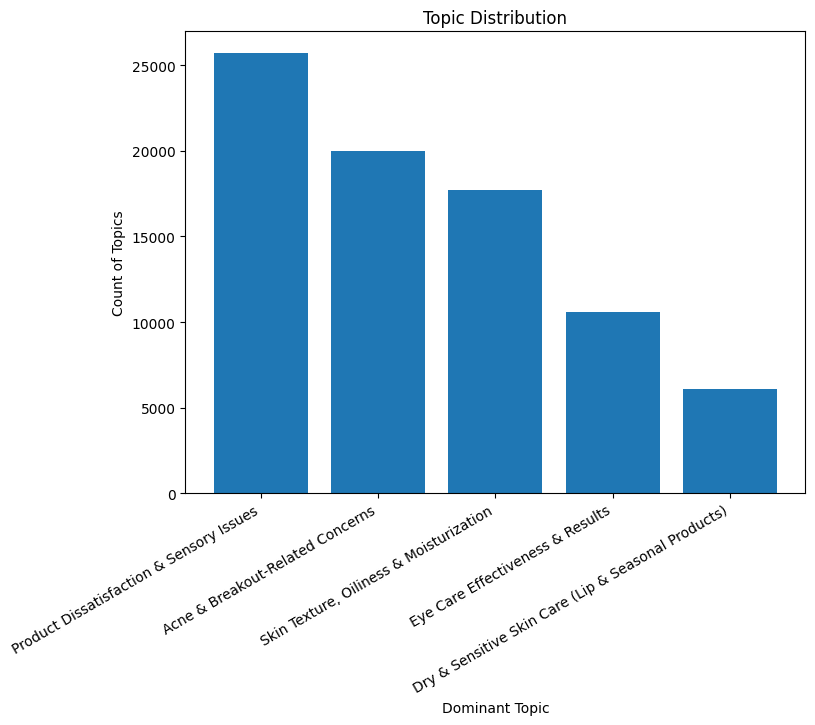

In [36]:
#topic distribution
import matplotlib.pyplot as plt
groupTopic = balanced_reviews['topic_labels'].value_counts()

plt.figure(figsize=(8,6))
plt.bar(groupTopic.index,groupTopic.values)
plt.xlabel('Dominant Topic')
plt.ylabel('Count of Topics')
plt.title('Topic Distribution')
plt.xticks(rotation=30, ha='right')
plt.show()

Analysis: Topic distribution indicates that product dissatisfaction dominates the customer discussion with acne breakouts or skin type concerns appearing most frequently

### Topic distribution Across Skin Types

<Figure size 600x400 with 0 Axes>

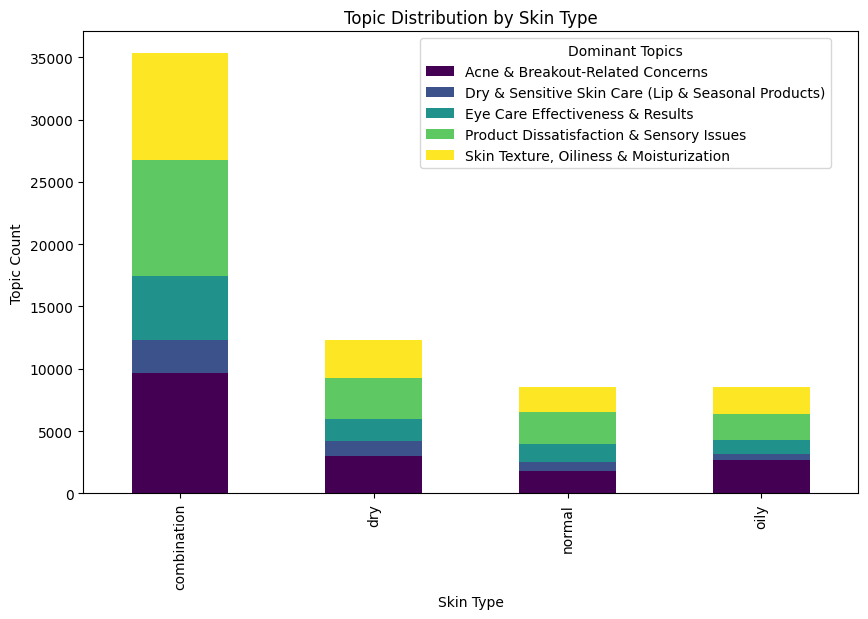

In [59]:
balanced_reviews.groupby(['skin_type','topic_labels']).size().reset_index(name='count').sort_values(by=['skin_type','count'],ascending=False)
group6 = balanced_reviews.groupby(['skin_type','topic_labels']).size().reset_index(name='count')

plt.figure(figsize=(6,4))
pivot_table = group6.pivot(index='skin_type',columns='topic_labels',values='count').fillna(0)
pivot_table.plot(kind='bar',stacked=True,figsize=(10,6),cmap='viridis')
plt.xlabel('Skin Type')
plt.ylabel('Topic Count')
plt.title('Topic Distribution by Skin Type')
plt.legend(title='Dominant Topics',bbox_to_anchor=(0.7,1),loc='upper center')
plt.show()

Analysis: Users with combination skin discusses topics related to acne, breakouts, texture and moisturization  while normal skin type users discusses topics around produt dissatisfaction concerns

### Ingredient-Specific concerns in Customer Reviews
Unrelated to above topics, we also explored commonly discussed cosmetic ingredient-related concerns, which made users raise concerns.

Considering some concerning ingredients that were mentioned in the user reviews are 'polyethylene','octocrylene','octisalate', 'octyl', 'myristate','myristyl','pinesol','cottonseed', 'benzophenone','cocoyl','isoparaffin'

In [ ]:
import re

# ingredient list
INGREDIENTS = ['polyethylene','octocrylene','octisalate', 'octyl', 'myristate','myristyl','cottonseed', 'benzophenone','cocoyl','isoparaffin']

# function to identify these mentioned ingredient in review text
def extract_ingredient(text,ingredients):
  if not isinstance(text,str):
    return None
  text = text.lower()
  for ing in ingredients:
    if re.search(rf'\b{ing}\b',text):
      return ing
  return None

# filter negative reviews
negative_reviews = df.loc[df['sentiment_label']=='negative'].copy()

# identifying ingredient mentions
negative_reviews['ingredient_mention'] = negative_reviews['review_text'].apply(
    lambda x: extract_ingredient(x, INGREDIENTS)
)

# reviews with concerning ingredients
ingredient_df = negative_reviews.dropna(subset=['ingredient_mention'])

Some sample reviews with these ingredient

In [58]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

ingredient_df[['ingredient_mention','review_text','skin_type','secondary_category']].head(5)

,ingredient_mention,review_text,skin_type,secondary_category
97476,cottonseed,"heartbroken that they claim to have replaced the Cottonseed with this. It is NOT the same at all. I had tried so many cleansers and once I found the Cottonseed I stuck to it and adored it. So heartbroken that it has been replaced and as a result, I am now back on the hunt for a good cleanser for my combination skin that also removes makeup. Sigh.",combination,Cleansers
97477,cottonseed,"Okay first off, those who are selling this as “the same cleanser as Cottonseed” you should know that Cottonseed is for normal to combo skin, this is not. It’s not a bad cleanser but it’s just not the same as the cottonseed. It starts off as a creamy cleanser, it does foam a bit but you don’t get that same “clean” feeling.. I dislike the fact that this is so highly scented.. I really wish they didn’t discontinue a great product.If you’re normal or dry this would be great for you. If you’re sensitive- stay away (too strong in fragrance it can be irritating)",combination,Cleansers
97521,cottonseed,"The product formula was changed from the cottonseed cleanser. Huge mistake. The original face wash was incredible. I used it for about least six years. Do not buy this to replace that formula. This new one smells weird, has a grainy texture, and just overall makes my skin feel gross.",combination,Cleansers
98383,polyethylene,"I’d give it 5 stars if it didn’t contain plastic (Polyethylene). Unfortunately, when it goes down the drain, it contributes to the plastic contamination of our waterways because our sewage systems have not been designed to filter out the microbeads :( As soon as I’ve finished the last jar in my stash, I’ll be looking for an alternative.",normal,Cleansers
98470,polyethylene,"I originally was going to purchase this until I saw it contains polyethylene, which is basically a plastic and has negative effects on the environment. I’d recommend a balm that doesn’t have polyethylene, like the Then I Met You balm. The prices are pretty similar, so I’d rather pay a couple more dollars rather than feel guilty when cleaning my face.",combination,Cleansers


Analysis : Ingredients such as polyethylene and cottonseed appear frequently in reviews associated with negative sentiment, particularly within cleansers categories, suggesting potential sensitivity concerns.

## Key Findings
- Skincare concerns dominate customer discussions, particularly acne,  sensitivity, and moisturization
- Topic prevalence varies significantly across skin types
- Certain ingredients are disproportionately associated with negative feedback
- Topic modeling complements sentiment analysis by explaining the drivers of customer dissatisfaction 